In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import scipy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

In [2]:
census_1850 = pd.read_csv("data/census_1850_indexUpdate.csv")
census_1880 = pd.read_csv("data/census_1880_mn_v04.csv")#select columns to use
cd_1880 = pd.read_csv("data/cd_1880.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
census_1880.columns

Index(['OBJECTID.x', 'CENSUS_MERGEID', 'CENSUS_SERIALB', 'CENSUS_SERIAL',
       'CENSUS_PERNUM', 'CENSUS_RECIDUS', 'CENSUS_REEL', 'CENSUS_VOLUME',
       'CENSUS_PAGENUM', 'CENSUS_NAMEFRSTB', 'CENSUS_NAMELASTB',
       'CENSUS_RELATE', 'CENSUS_RELATE_STR', 'CENSUS_AGE', 'CENSUS_SEXB',
       'CENSUS_RACENAMEB', 'CENSUS_RACEB', 'CENSUS_NPERHHB',
       'CENSUS_OCCLABELB', 'CENSUS_SEIUSBN', 'CENSUS_MATCH_ADDR',
       'CENSUS_HOUSE_NUMB', 'CENSUS_STREETB', 'CENSUS_TYPEB',
       'CENSUS_SEGMENT_ID', 'CENSUS_BUILDING_I', 'CENSUS_NEIGHBOR_1',
       'CENSUS_NEIGHBOR_2', 'CENSUS_SEGGROUP_I', 'CENSUS_EXTGROUP_I',
       'CENSUS_CITY', 'CENSUS_COUNTYUS', 'CENSUS_X', 'CENSUS_Y',
       'CENSUS_ADDRESS', 'CENSUS_ENUMDIST', 'CENSUS_CITYNAME',
       'CENSUS_STATENAME', 'CENSUS_UNITTYPE', 'MERGE_SRC', 'WARD_NUM',
       'CENSUS_AD'],
      dtype='object')

In [4]:
def create_street_house(df, address):
    df[["house_number", "street_name"]] = df[address].str.split(" ", 1, expand = True)
    df["house_number"] = df["house_number"].str.extract(r'(\d+)')#.astype('int64', errors = 'ignore') #deal with numbers when they are listed as 124-125 (choose the first one) there's also one that's 2A which becomes 2 
    df["house_number"] = df["house_number"].apply(pd.to_numeric, errors='coerce').dropna()

In [5]:
census_1880_model = census_1880.loc[:,["CENSUS_PAGENUM", "CENSUS_AGE", "CENSUS_ADDRESS", "WARD_NUM"]]
create_street_house(census_1880_model, "CENSUS_ADDRESS")

In [6]:
def get_street_type(df):
    types = ["PL","AVE", "ALY", "ISLAND", "CT", "ST", "SQ", "RD", "PARK", "PIER"]
    exp = '(?<!\S)({})(?!\S)'.format('|'.join(types))
    df["street_type"] = df["street_name"].str.extract(exp, expand = True).fillna("None")

def get_street_dir(df):
    directions = ["S", "N", "W", "E"]
    exp = '(?<!\S)({})(?!\S)'.format('|'.join(directions))
    df["street_dir"] = df["street_name"].str.extract(exp, expand = True).fillna("None")
    
get_street_type(census_1880_model)
get_street_dir(census_1880_model)

In [7]:
census_1880_model["street_type"].value_counts()

ST        909324
AVE       162459
None       19279
PL         15183
ISLAND      4781
PARK        4201
SQ          1339
PIER         566
RD           163
ALY          109
CT            75
Name: street_type, dtype: int64

In [8]:
census_1880_model["street_dir"].value_counts()

None    541290
E       313304
W       253426
S         5152
N         4307
Name: street_dir, dtype: int64

In [9]:
onehot_encode = ["street_dir", "street_type"]
target_encode = ["street_name", "WARD_NUM"]
continuous = ["CENSUS_AGE", "CENSUS_PAGENUM"]

In [10]:
wards = [3, 18, 22]
census_1880_model_train = census_1880_model[~census_1880_model["WARD_NUM"].isin(wards)].copy()
census_1880_model_test = census_1880_model[census_1880_model["WARD_NUM"].isin(wards)]

In [11]:
census_1880_model_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948667 entries, 0 to 1117478
Data columns (total 8 columns):
CENSUS_PAGENUM    948667 non-null int64
CENSUS_AGE        948667 non-null int64
CENSUS_ADDRESS    948667 non-null object
WARD_NUM          941189 non-null float64
house_number      948667 non-null int64
street_name       948667 non-null object
street_type       948667 non-null object
street_dir        948667 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 65.1+ MB


In [12]:
census_1880_model_train.fillna(value = {"WARD_NUM":"None"}, inplace = True)
census_1880_model_train_y = census_1880_model_train["house_number"]
census_1880_model_train_X = census_1880_model_train.drop(labels = ["house_number", "CENSUS_ADDRESS"], axis = 1)

In [13]:
preprocess = make_column_transformer((OneHotEncoder(), onehot_encode),
                                     (StandardScaler(), continuous),
                                     (TargetEncoder(), target_encode))
model = Pipeline([('preprocess', preprocess),
                  ('regressor', LinearRegression())])

In [14]:
model.fit(census_1880_model_train_X, census_1880_model_train_y)
print("Training Score:", model.score(census_1880_model_train_X, census_1880_model_train_y))

Training Score: 0.6740163507722179


In [15]:
census_1880_model_test_y = census_1880_model_test["house_number"]
census_1880_model_test_X = census_1880_model_test.drop(labels = ["house_number", "CENSUS_ADDRESS"], axis = 1)
print("1880 Test Score:", model.score(census_1880_model_test_X, census_1880_model_test_y))

1880 Test Score: -1.2170623593281378


In [16]:
census_filled_1850 = pd.read_csv("data/dwelling_filled_sum_1850_mn.csv")
census_filled_1850.dropna(subset = ["CD_ADDRESS"], inplace = True)
census_filled_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261460 entries, 0 to 515615
Data columns (total 30 columns):
CENSUS_SERIALP             261460 non-null int64
CENSUS_AGE                 261460 non-null int64
CENSUS_SEX                 261460 non-null int64
CENSUS_MARST               261460 non-null int64
CENSUS_RACE                261460 non-null int64
CENSUS_LABFORCE            261460 non-null int64
CENSUS_IMPREL              261460 non-null int64
CENSUS_OCCSTR              83888 non-null object
CENSUS_NAMELAST            261405 non-null object
CENSUS_NAMEFRST            261158 non-null object
CENSUS_SEQ_NUM             261460 non-null int64
CENSUS_HH_NUM              261460 non-null int64
CENSUS_IPUMS_UID           261460 non-null object
CENSUS_CITY                261460 non-null int64
CENSUS_PAGENO_HOUSEHOLD    261460 non-null int64
CENSUS_WARD_NUM            261460 non-null int64
CENSUS_REEL_HOUSEHOLD      261460 non-null int64
CENSUS_PLACE               261460 non-null object
CEN

In [17]:
census_filled_1850 = census_filled_1850.loc[:,["CD_ADDRESS", "CENSUS_PAGENO_HOUSEHOLD", "CENSUS_AGE", "CENSUS_WARD_NUM"]]
census_filled_1850.rename(columns = {"CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_WARD_NUM":"WARD_NUM"}, inplace = True)
create_street_house(census_filled_1850, "CD_ADDRESS")
census_filled_1850.dropna(subset = ["street_name", "house_number"], inplace = True)
census_filled_1850.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259173 entries, 0 to 515615
Data columns (total 6 columns):
CD_ADDRESS        259173 non-null object
CENSUS_PAGENUM    259173 non-null int64
CENSUS_AGE        259173 non-null int64
WARD_NUM          259173 non-null int64
house_number      259173 non-null float64
street_name       259173 non-null object
dtypes: float64(1), int64(3), object(2)
memory usage: 13.8+ MB


In [18]:
get_street_type(census_filled_1850)
get_street_dir(census_filled_1850)
census_filled_1850_y = census_filled_1850["house_number"]
census_filled_1850_X = census_filled_1850.drop(labels = ["house_number", "CD_ADDRESS"], axis = 1)
print("1850 Test Score:", model.score(census_filled_1850_X, census_filled_1850_y))

1850 Test Score: -2.505618753493405


#### Redo outside pipeline to look at feature importances

In [19]:
#Let's see which features the model considered important
ohe = OneHotEncoder()
te = TargetEncoder()
OHE = ohe.fit_transform(census_1880_model_train_X.loc[:,onehot_encode])
TE = te.fit_transform(census_1880_model_train_X.loc[:,target_encode], census_1880_model_train_y)
C = StandardScaler().fit_transform(census_1880_model_train_X.loc[:,continuous])
X = scipy.sparse.hstack((OHE, TE, C))

In [20]:
cols = list(ohe.get_feature_names()) + list(te.get_feature_names()) + continuous

In [21]:
lin_mod = LinearRegression().fit(X, census_1880_model_train_y)
coefs = lin_mod.coef_

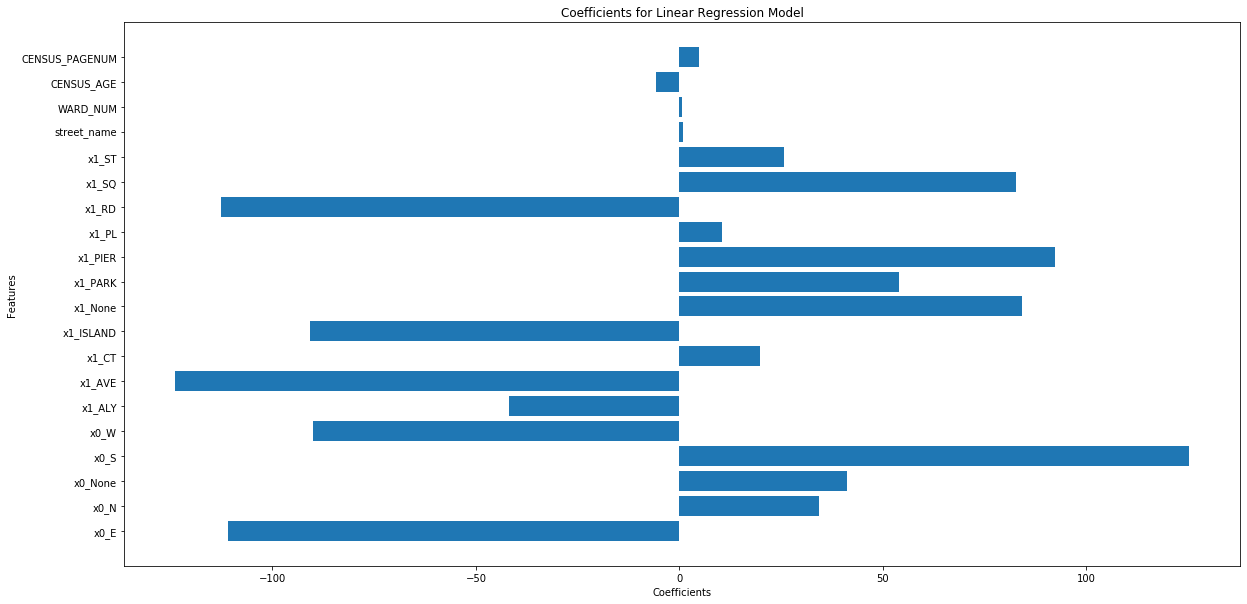

In [22]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(cols, coefs)
ax.set_title("Coefficients for Linear Regression Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

Training score without intercept: 0.6740160881260632


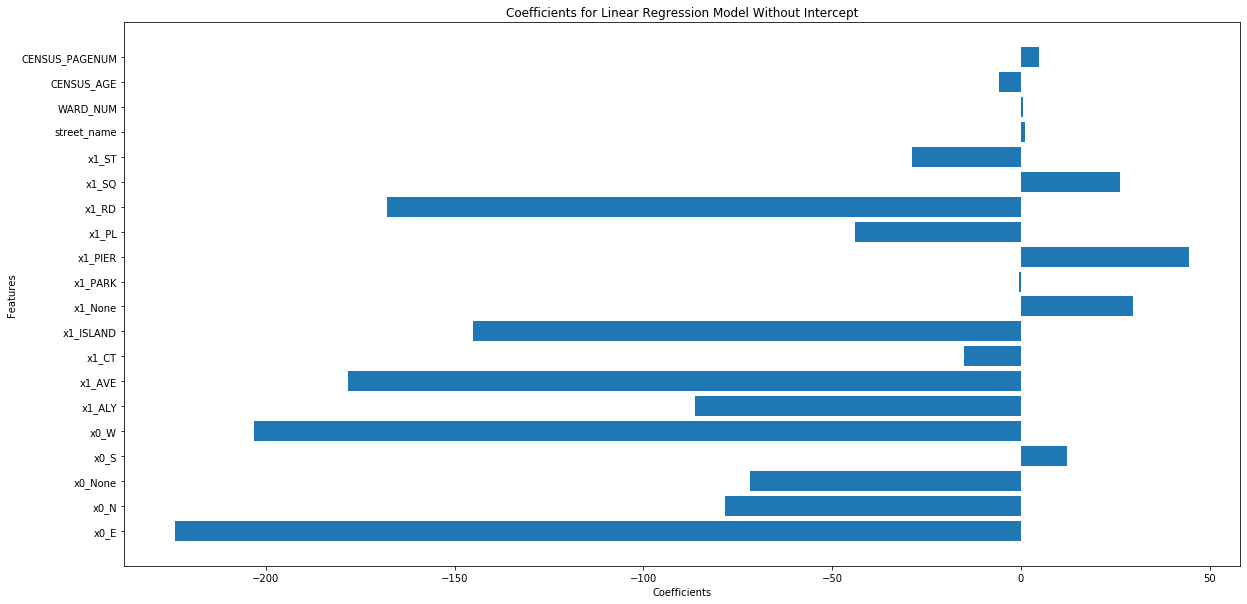

In [23]:
lin_mod = LinearRegression(fit_intercept = False).fit(X, census_1880_model_train_y)
print("Training score without intercept:", lin_mod.score(X, census_1880_model_train_y))
coefs = lin_mod.coef_
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(cols, coefs)
ax.set_title("Coefficients for Linear Regression Model Without Intercept")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

So this is not succeeding at generalizing at all. Let's see if regularization helps, if not we'll need to try something else.

In [24]:
ridge = Pipeline([('preprocess', preprocess),
                  ('regressor', Ridge(alpha = 1000))])
ridge.fit(census_1880_model_train_X, census_1880_model_train_y)
print("Training Score:", ridge.score(census_1880_model_train_X, census_1880_model_train_y))
print("1880 Test Score:", ridge.score(census_1880_model_test_X, census_1880_model_test_y))
print("1850 Test Score:", ridge.score(census_filled_1850_X, census_filled_1850_y))

Training Score: 0.6739360661757745
1880 Test Score: -1.1995624678926275
1850 Test Score: -2.434948868979194


In [25]:
from sklearn.linear_model import Lasso
lasso = Pipeline([('preprocess', preprocess),
                  ('regressor', Lasso(alpha = 10000))])
lasso.fit(census_1880_model_train_X, census_1880_model_train_y)
print("Training Score:", lasso.score(census_1880_model_train_X, census_1880_model_train_y))
print("1880 Test Score:", lasso.score(census_1880_model_test_X, census_1880_model_test_y))
print("1850 Test Score:", lasso.score(census_filled_1850_X, census_filled_1850_y))

Training Score: 0.6302438799830188
1880 Test Score: -0.7951653776170111
1850 Test Score: -0.5314334575844806


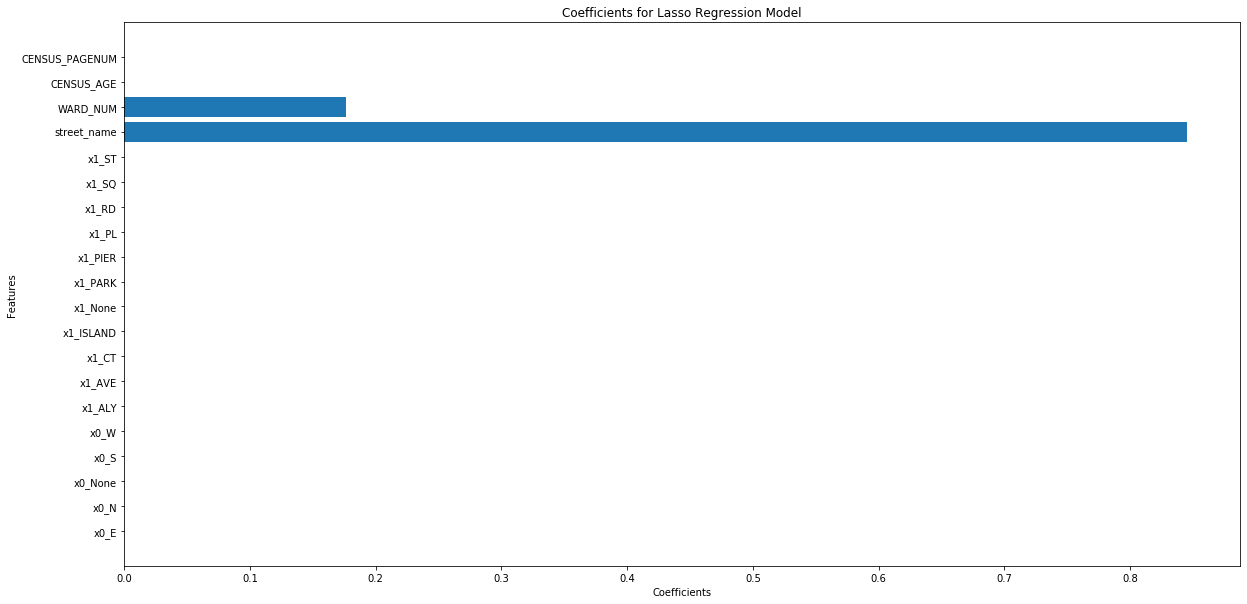

In [26]:
###Let's look at lasso's importance since it seems to work better (slightly)
las_mod = Lasso(alpha = 10000).fit(X, census_1880_model_train_y)
coefs = las_mod.coef_
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(cols, coefs)
ax.set_title("Coefficients for Lasso Regression Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [27]:
las_mod.coef_

array([-0.        , -0.        ,  0.        ,  0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        ,  0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        ,  0.8451377 ,  0.17663289, -0.        ,  0.        ])

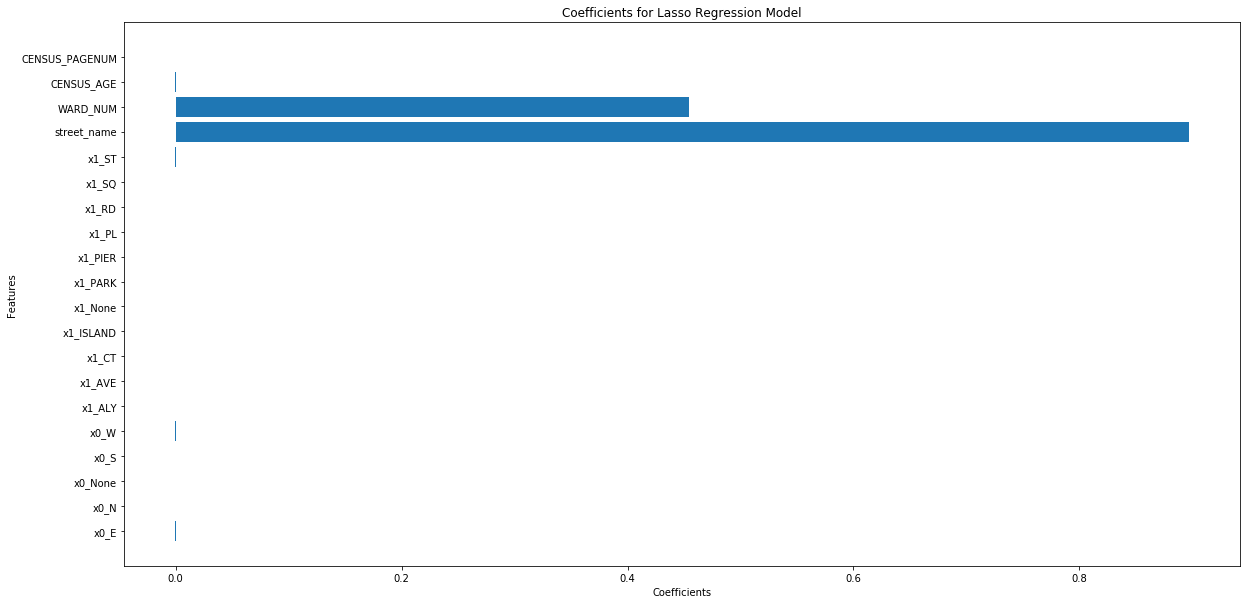

In [28]:
ridge_mod = Ridge(alpha = 10000).fit(X, census_1880_model_train_y)
coefs = ridge_mod.coef_
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(cols, coefs)
ax.set_title("Coefficients for Lasso Regression Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

#### Model only with Ward_Num and street_name, as indicated by regularization

Training score with feature selection: 0.6338962828802052


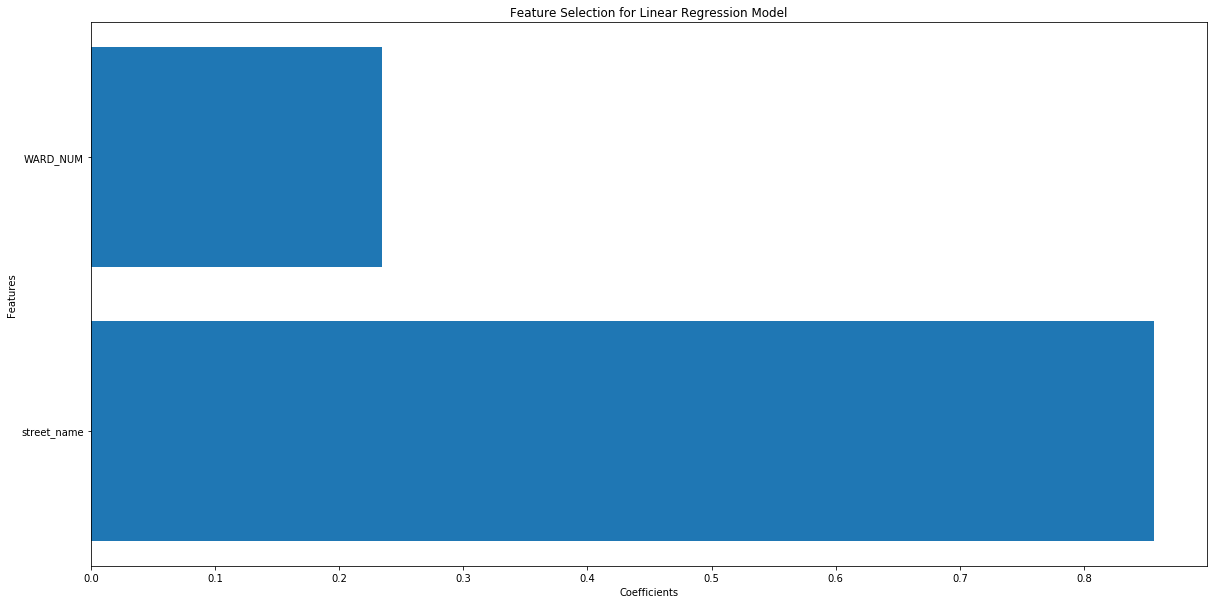

In [29]:
### Let's try just using WARD_NUM and street_name
lin_feat = LinearRegression(fit_intercept = False).fit(TE, census_1880_model_train_y)
coefs = lin_feat.coef_
print("Training score with feature selection:", lin_feat.score(TE, census_1880_model_train_y))
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(te.get_feature_names(), coefs)
ax.set_title("Feature Selection for Linear Regression Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [30]:
te_test = TargetEncoder()
te_1850 = TargetEncoder()
X_te_1880 = te_test.fit_transform(census_1880_model_test_X.loc[:,target_encode], census_1880_model_test_y)
X_te_1850 = te_1850.fit_transform(census_filled_1850_X.loc[:,target_encode], census_filled_1850_y)

In [31]:
print("1880 test score with feature selection:", lin_feat.score(X_te_1880, census_1880_model_test_y))
print("1850 test score with feature selection:", lin_feat.score(X_te_1850, census_filled_1850_y))

1880 test score with feature selection: 0.606208092857389
1850 test score with feature selection: 0.5272094558677243


This is a good indication that a model can successfully be trained on 1880 and tested on 1850 (but perhaps we can use some of 1850 in the training data)

#### Add some of the 1850 data to the training set

In [32]:
X_1850_train, X_1850_test, y_1850_train, y_1850_test = train_test_split(census_filled_1850_X.loc[:,target_encode], census_filled_1850_y, random_state = 123)
X_1880_1850 = pd.concat([census_1880_model_train_X.loc[:,target_encode], X_1850_train])
y_1880_1850 = pd.concat([census_1880_model_train_y, y_1850_train])

In [33]:
X_1880_1850_te = te.fit_transform(X_1880_1850, y_1880_1850)
X_1850_test_te = te.fit_transform(X_1850_test, y_1850_test)

In [34]:
lin_feat = LinearRegression(fit_intercept = False).fit(X_1880_1850_te, y_1880_1850)
print("Training score with 1880 and 1850 data:", lin_feat.score(X_1880_1850_te, y_1880_1850))
print("1880 test score:", lin_feat.score(X_te_1880, census_1880_model_test_y))
print("1850 test score:", lin_feat.score(X_1850_test_te, y_1850_test))

Training score with 1880 and 1850 data: 0.6392200135138517
1880 test score: 0.6087932645160461
1850 test score: 0.5420903968340011


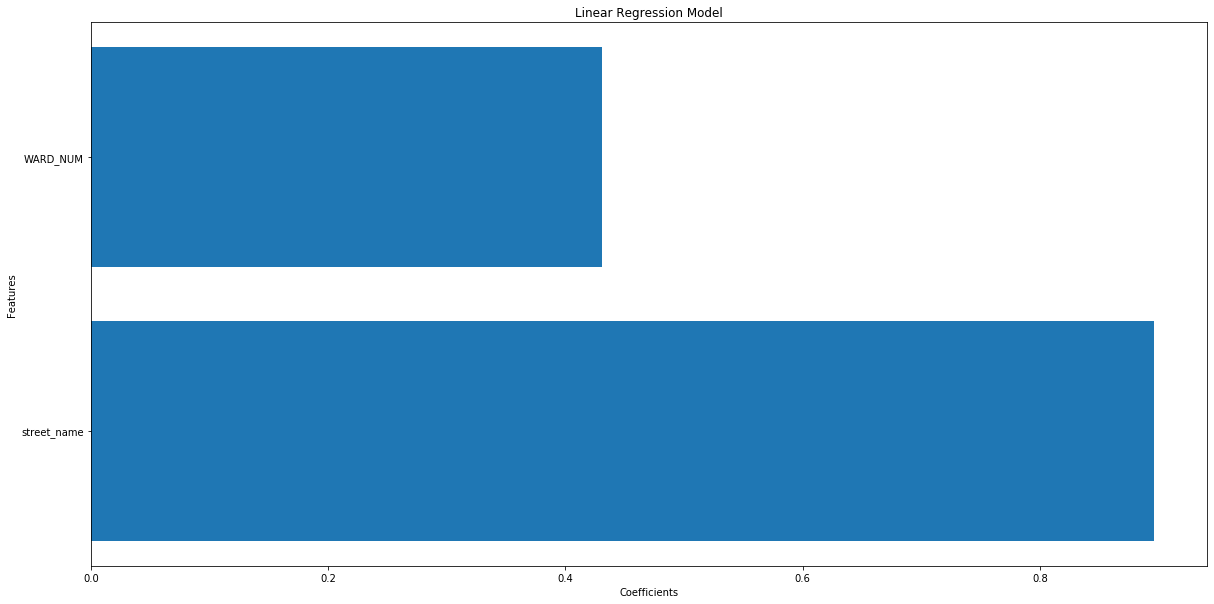

In [45]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(te.get_feature_names(), lin_feat.coef_)
ax.set_title("Linear Regression Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [46]:
lin_feat.coef_

array([0.89591116, 0.43081183])

#### Find best linear regression model

In [35]:
print("Linear Regression without intercept")
lin_feat = LinearRegression().fit(X_1880_1850_te, y_1880_1850)
print("Training score with 1880 and 1850 data:", lin_feat.score(X_1880_1850_te, y_1880_1850))
print("1880 test score:", lin_feat.score(X_te_1880, census_1880_model_test_y))
print("1850 test score:", lin_feat.score(X_1850_test_te, y_1850_test))

Linear Regression without intercept
Training score with 1880 and 1850 data: 0.6564545351965811
1880 test score: 0.39042665655723663
1850 test score: 0.5098115059176744


In [36]:
print("Ridge Model")
param_grid_ridge = {"alpha":[5000000, 8000000, 10000000], "fit_intercept":[True, False]}
Ridge_Grid = GridSearchCV(Ridge(), param_grid = param_grid_ridge).fit(X_1880_1850_te, y_1880_1850)
print(Ridge_Grid.best_estimator_)

Ridge Model
Ridge(alpha=10000000, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)


In [47]:
Ridge_Grid.best_estimator_.coef_

array([0.89582803, 0.43073655])

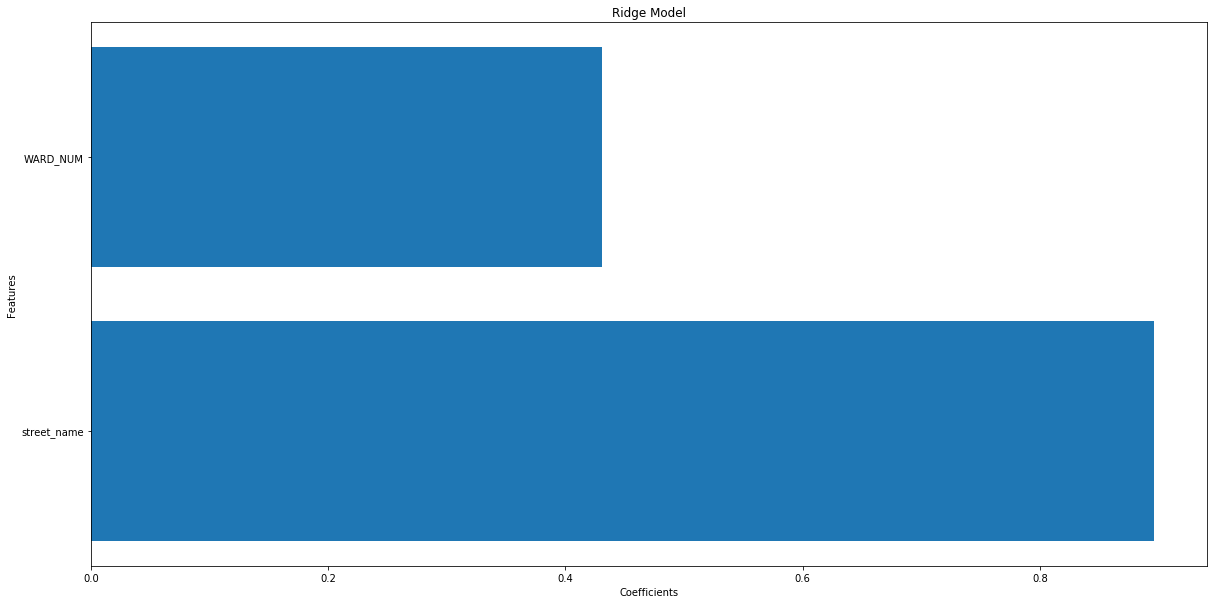

In [43]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(te.get_feature_names(), Ridge_Grid.best_estimator_.coef_)
ax.set_title("Ridge Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [38]:
print("Training score with 1880 and 1850 data:", Ridge_Grid.score(X_1880_1850_te, y_1880_1850))
print("1880 test score:", Ridge_Grid.score(X_te_1880, census_1880_model_test_y))
print("1850 test score:", Ridge_Grid.score(X_1850_test_te, y_1850_test))

Training score with 1880 and 1850 data: 0.656454527708188
1880 test score: 0.3904622769999586
1850 test score: 0.509853488463688


In [39]:
print("Lasso Model")
param_grid_lasso = {"alpha":[3700, 3800, 3900], "fit_intercept":[True, False]}
Lasso_Grid = GridSearchCV(Lasso(), param_grid = param_grid_lasso).fit(X_1880_1850_te, y_1880_1850)
print(Lasso_Grid.best_estimator_)

Lasso Model
Lasso(alpha=3900, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [40]:
print("Training score with 1880 and 1850 data:", Lasso_Grid.score(X_1880_1850_te, y_1880_1850))
print("1880 test score:", Lasso_Grid.score(X_te_1880, census_1880_model_test_y))
print("1850 test score:", Lasso_Grid.score(X_1850_test_te, y_1850_test))

Training score with 1880 and 1850 data: 0.6520672215133161
1880 test score: 0.4971463237426117
1850 test score: 0.538747495695554


In [48]:
Lasso_Grid.best_estimator_.coef_

array([0.87419744, 0.31203939])

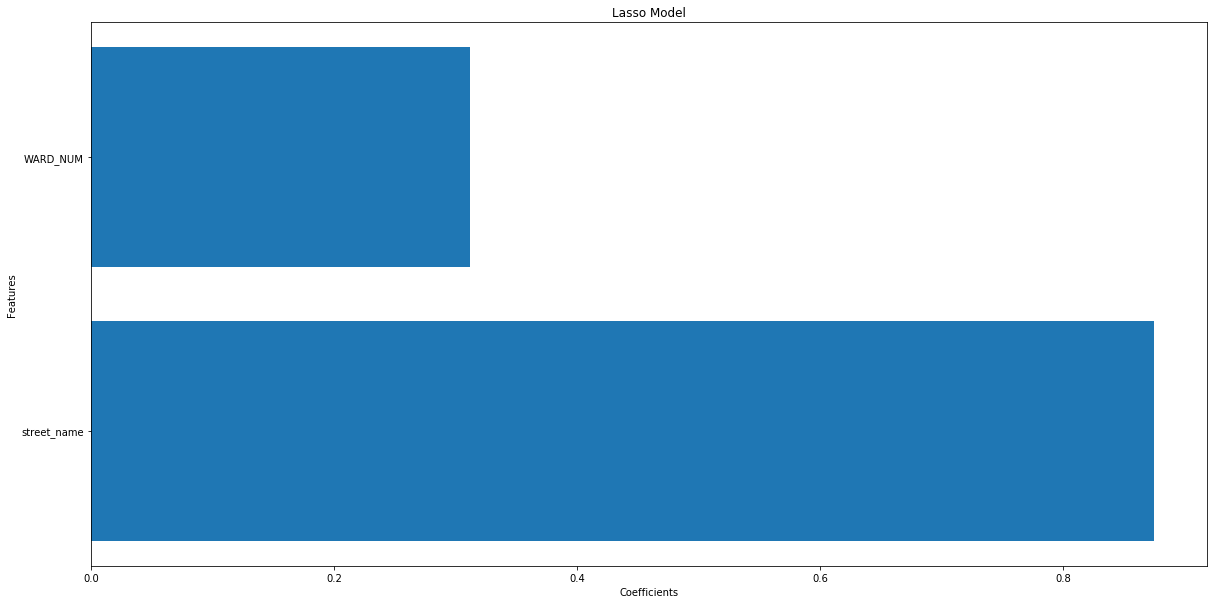

In [44]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(te.get_feature_names(), Lasso_Grid.best_estimator_.coef_)
ax.set_title("Lasso Model")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [41]:
print("Elastic Model")
param_grid_elastic = {"alpha":[9000, 10000, 11000], "fit_intercept":[True, False], "l1_ratio":[0.05, 0.1]}
Elastic_Grid = GridSearchCV(ElasticNet(), param_grid = param_grid_elastic).fit(X_1880_1850_te, y_1880_1850)
print(Elastic_Grid.best_estimator_)

Elastic Model
ElasticNet(alpha=11000, copy_X=True, fit_intercept=True, l1_ratio=0.05,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [42]:
print("Training score with 1880 and 1850 data:", Elastic_Grid.score(X_1880_1850_te, y_1880_1850))
print("1880 test score:", Elastic_Grid.score(X_te_1880, census_1880_model_test_y))
print("1850 test score:", Elastic_Grid.score(X_1850_test_te, y_1850_test))

Training score with 1880 and 1850 data: 0.6468881784390397
1880 test score: 0.4179462755272336
1850 test score: 0.5350912992083139


#### Let's try adding in enumeration order

In [70]:
#Start with just 1880 data and simple ordinal encoding/simple groupby approach to generating order
train_1880 = census_1880_model_train_X.loc[:,target_encode]

def order(df, col):
    df[col] = list(range(len(df)))
    return df

def get_enumorder_groupby(df, ward = "WARD_NUM", street = "street_name"):
    #df = df.groupby(ward).apply(lambda x: order(x, "ward_order"))
    df = df.groupby([ward, street]).apply(lambda x: order(x, "street_order"))
    return df
    
train_1880 = get_enumorder_groupby(train_1880)
train_1880.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 948667 entries, 0 to 1117478
Data columns (total 3 columns):
street_name     948667 non-null object
WARD_NUM        948667 non-null object
street_order    948667 non-null int64
dtypes: int64(1), object(2)
memory usage: 69.0+ MB


In [71]:
preprocess_te = make_column_transformer((TargetEncoder(), target_encode), remainder = "passthrough")
param_grid_lin = {"fit_intercept":[True, False]}
Lin_Grid = GridSearchCV(LinearRegression(), param_grid = param_grid_lin)
model_lin = Pipeline([('preprocess', preprocess_te),
                      ('regressor', Lin_Grid)])
model_lin.fit(train_1880, census_1880_model_train_y)
print("Training Score:", model_lin.score(train_1880, census_1880_model_train_y))

Training Score: 0.6697534990447203


In [72]:
test_1880 = get_enumorder_groupby(census_1880_model_test_X.loc[:,target_encode])
test_1850 = get_enumorder_groupby(census_filled_1850_X.loc[:,target_encode])
print("1880 Test Score:", model_lin.score(test_1880, census_1880_model_test_y))
print("1850 Test Score:", model_lin.score(test_1850, census_filled_1850_y))

1880 Test Score: -0.730684642803636
1850 Test Score: -0.07568276791188389


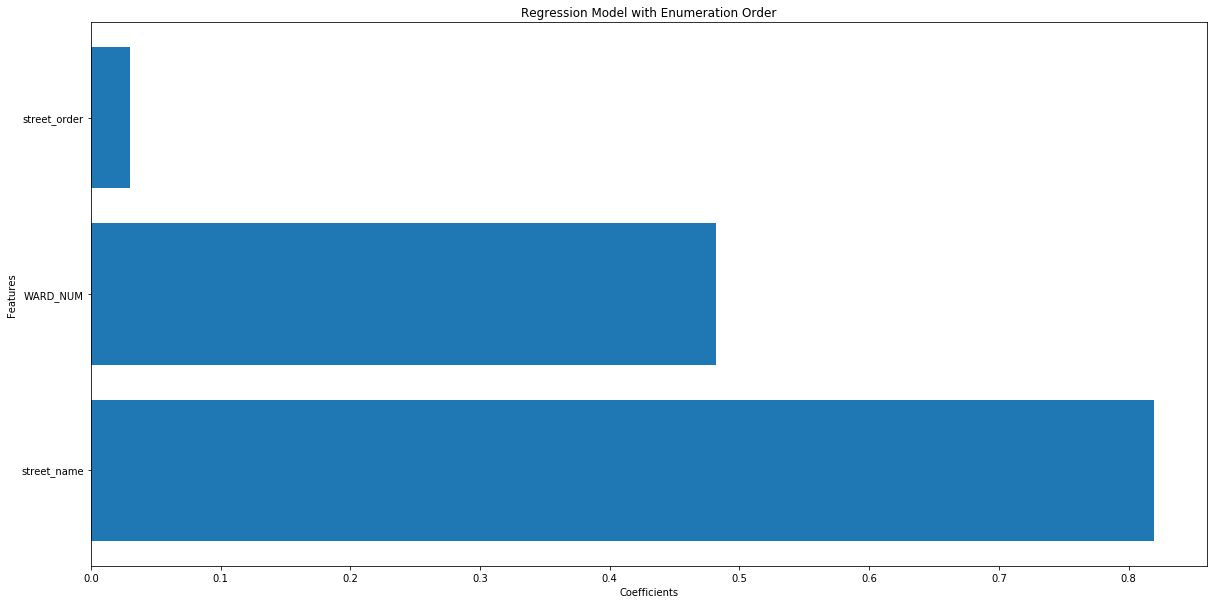

In [73]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(te.get_feature_names() + ["street_order"], model_lin.named_steps["regressor"].best_estimator_.coef_)
ax.set_title("Regression Model with Enumeration Order")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [74]:
model_lin.named_steps["regressor"].best_estimator_.coef_

array([0.8193742 , 0.48210214, 0.02998694])

In [78]:
#Let's try targeting encoding the enum order too
model_lin_teall = Pipeline([('preprocess', TargetEncoder()),
                            ('regressor', Lin_Grid)])
model_lin_teall.fit(train_1880, census_1880_model_train_y)
print("Training Score:", model_lin_teall.score(train_1880, census_1880_model_train_y))
print("1880 Test Score:", model_lin_teall.score(test_1880, census_1880_model_test_y))
print("1850 Test Score:", model_lin_teall.score(test_1850, census_filled_1850_y))

Training Score: 0.6697534990447203
1880 Test Score: -0.730684642803636
1850 Test Score: -0.07568276791188389


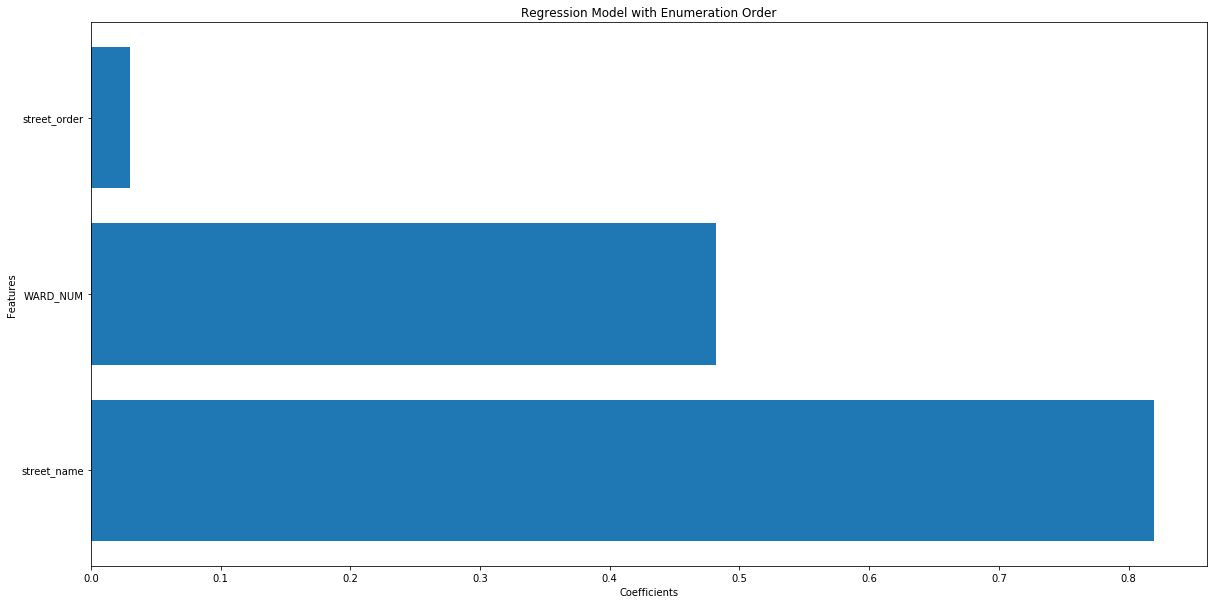

In [76]:
fig, ax = plt.subplots(1, figsize=(20,10))
ax.barh(model_lin_teall.named_steps['preprocess'].get_feature_names(), model_lin_teall.named_steps["regressor"].best_estimator_.coef_)
ax.set_title("Regression Model with Enumeration Order")
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")
plt.show()

In [80]:
#Including the enumeration order means it's really not generalizing well, for thoroughness
#I'll test adding in some of the 1850 data
train_1850_order_X, test_1850_order_X, train_1850_order_y, test_1850_order_y = train_test_split(test_1850, census_filled_1850_y)
train_1850_1880_order_X = pd.concat([train_1880, train_1850_order_X])
train_1850_1880_order_y = pd.concat([census_1880_model_train_y, train_1850_order_y])

In [81]:
model_lin_8050 = Pipeline([('preprocess', TargetEncoder()),
                            ('regressor', Lin_Grid)])
model_lin_8050.fit(train_1850_1880_order_X, train_1850_1880_order_y)
print("Training Score:", model_lin_8050.score(train_1880, census_1880_model_train_y))
print("1880 Test Score:", model_lin.score(test_1880, census_1880_model_test_y))
print("1850 Test Score:", model_lin.score(test_1850_order_X, test_1850_order_y))

Training Score: 0.6686345957118405
1880 Test Score: -0.7054897258809816
1850 Test Score: -0.17230017306580958


So this clearly didn't work well, I think it's a good indication that it would be worth exploring other ways of expressing enumeration order. Perhaps block number would work well? 